# Simple Detection Evaluation 

### Leval 1. Binary Evaluation - Species Present vs Not-Present in image
**Evaluating the performance of object detector on classifying task, i.e - performance on finding the species in images**

1. Overall Level
2. Species level

### Level 2. Species Count 
1. Overall level
2. Speceis level
3. Count level

### Level 3. Incorporate IoU
[Look at this when writing](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

## Level 1: Overall Level
1. Filter out the images that were not user for model training
2. Make predictions on these images
    - wait, we can run the predictions on all the image and then do the step 1
3. Run the queries - predictorExtractor_main.py and prediction_groundtruth_consolidation_main.py
4. Evaluate predictions

In [1]:
# importing the necessary librabies
import csv, glob
import pandas as pd
import numpy as np
import sklearn.metrics as metric
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

In [35]:
# Working with the older dataset for building this
filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/round1/pred_groundtruth_consolidate_snapshot_serengeti_s01_s06_0_199999-00000-of-00100.csv"
df_pred_gt_consolidated = pd.read_csv(filepath)
df_pred_gt_consolidated = df_pred_gt_consolidated.fillna(0)
df_pred_gt_consolidated.tail()

,filename,species,labels,groundtruth_counts,prediction_counts
3638,S6/V10/V10_R1/S6_V10_R1_IMAG0574,impala,10,0,1
3639,S6/V10/V10_R1/S6_V10_R1_IMAG1213,elephant,11,0,1
3640,S6/V10/V10_R1/S6_V10_R1_IMAG1213,buffalo,14,0,1
3641,S6/V10/V10_R1/S6_V10_R1_IMAG1373,hartebeest,15,0,1
3642,S6/V10/V10_R1/S6_V10_R1_IMAG1373,lionFemale,20,0,1


In [2]:
# Consolidate all the prediction_groundtruth shards
filepath_list = glob.glob("/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/round1/pred_groundtruth_consolidate_snapshot_serengeti_s01_s06_0_199999-00000-of-00100.csv")
def combine_pred_groundtruth_consolidated_files(filepath_list):
    """This function combines all the small shards pred_groundtruth_consolidate_snapshot_serengeti_s01_s06
    into a big file.
    Parameter: filepath for the pred_groundtruth_consolidate_snapshot_serengeti_s01_s06*
    Return: consolidated datframe
    """
    df_pred_gt_consolidated = pd.DataFrame()
    list_temp = []
    for i, filepath in enumerate(filepath_list):
        df_pred_gt_temp = pd.read_csv(filepath)
        df_pred_gt_temp = df_pred_gt_temp.fillna(0)
        list_temp.append(df_pred_gt_temp.shape[0]) # for use to check the correct append. len(list_temp)== 400
        df_pred_gt_consolidated = df_pred_gt_consolidated.append(df_pred_gt_temp)
    return df_pred_gt_consolidated

In [3]:
df_pred_gt_consolidated = combine_pred_groundtruth_consolidated_files(filepath_list)
df_pred_gt_consolidated.tail()

,filename,species,labels,groundtruth_counts,prediction_counts
3638,S6/V10/V10_R1/S6_V10_R1_IMAG0574,impala,10,0,1
3639,S6/V10/V10_R1/S6_V10_R1_IMAG1213,elephant,11,0,1
3640,S6/V10/V10_R1/S6_V10_R1_IMAG1213,buffalo,14,0,1
3641,S6/V10/V10_R1/S6_V10_R1_IMAG1373,hartebeest,15,0,1
3642,S6/V10/V10_R1/S6_V10_R1_IMAG1373,lionFemale,20,0,1


### Level 1:

In [53]:
y_true = [val != 0 for val in df_pred_gt_consolidated["groundtruth_counts"]]
y_pred = [val != 0 for val in df_pred_gt_consolidated["prediction_counts"]]
print(sum(y_true), sum(y_pred))

814114 1287168


In [54]:
tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
print(metric.confusion_matrix(y_true, y_pred))
print(tn, fp, fn, tp)

[[     0 581750]
 [108696 705418]]
0 581750 108696 705418


In [55]:
# For a classification task the recall is:
recall = round(tp/(tp + fn), 3) # Correct
precision = round(tp/(tp + fp), 3)
accuracy = round((tp+tn)/(tp + fn + fp + tn), 3)
f1_score = round(2*recall*precision/(recall + precision), 3)

print("Recall: {0}".format(recall))
print("Precision: {0}".format(precision))
print("F1-Score: {0}".format(f1_score))
print("Accuracy: {0}".format(accuracy))
      

Recall: 0.866
Precision: 0.548
F1-Score: 0.671
Accuracy: 0.505


Confusion matrix, without normalization
[[     0 581750]
 [108696 705418]]


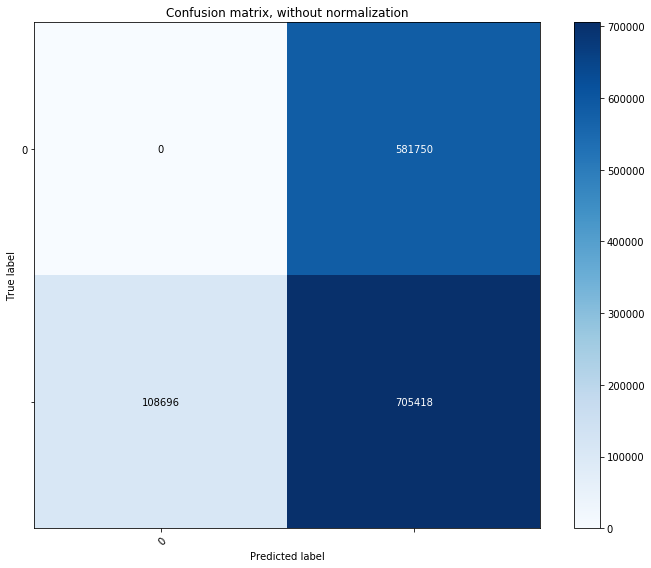

In [56]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metric.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=np.array(['1', '0']),
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_true, y_pred, classes=np.array(['false', 'true']), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

## Level 1. Species level

In [65]:
species_level_performance_binary = {}
for species in set(df_pred_gt_consolidated['species']):
    species_level_performance_binary[species] = {}
    error = False
    df_temp = df_pred_gt_consolidated[df_pred_gt_consolidated['species']==species]
    y_true = [val != 0 for val in df_temp["groundtruth_counts"]]
    y_pred = [val != 0 for val in df_temp["prediction_counts"]]
    try:
        tn, fp, fn, tp = metric.confusion_matrix(y_true, y_pred).ravel()
    except Exception:
#         y_true = [2] # to know why this exception run this code
#         y_pred = [2]
#         int(confusion_matrix(y_true, y_pred))
        tn, fp, fn, tp = 0, 0, 0, int(metric.confusion_matrix(y_true, y_pred))
        pass

    species_level_performance_binary[species]['TP'] = tp
    species_level_performance_binary[species]['FP'] = fp
    species_level_performance_binary[species]['TN'] = tn
    species_level_performance_binary[species]['FN'] = fn
    
#     recall = round(tp/(tp + fn), 3)
#     precision = round(tp/(tp + fp), 3)
#     accuracy = round((tp+tn)/(tp + fn + fp + tn), 3)
#     f1_score = round(2*recall*precision/(recall + precision), 3)
#     print(metric.confusion_matrix(y_true, y_pred))
#     print("Recall: {0}".format(recall))
#     print("Precision: {0}".format(precision))
#     print("F1-Score: {0}".format(f1_score))
#     print("Accuracy: {0}".format(accuracy))
#     print("\n")

In [81]:
species_level_performance_binary_df = pd.DataFrame(species_level_performance_binary).transpose().reset_index()
# species_level_performance_binary_df.to_csv('species_level_performance_binary_df.csv')
species_level_performance_binary_df.head()

,index,FN,FP,TN,TP
0,aardvark,44,584,0,213
1,aardwolf,40,61,0,64
2,baboon,799,2910,0,3233
3,batEaredFox,133,701,0,256
4,buffalo,5566,74293,0,27406


In [63]:
df_pred_gt_consolidated[(df_pred_gt_consolidated.species=='lionFemale') & (df_pred_gt_consolidated.groundtruth_counts!=0)].head()

,filename,species,labels,groundtruth_counts,prediction_counts
1973,S2/E09/E09_R3/S2_E09_R3_IMAG0344,lionFemale,20,3,1
1974,S3/I13/I13_R11/S3_I13_R11_IMAG0534,lionFemale,20,2,2
1975,S3/M08/M08_R12/S3_M08_R12_IMAG1015,lionFemale,20,4,2
1976,S4/J12/J12_R1/S4_J12_R1_IMAG0101,lionFemale,20,3,2
1977,S1/F10/F10_R1/S1_F10_R1_PICT0441,lionFemale,20,6,6


In [87]:
image_frequency_per_species = pd.read_csv("./image_frequency_per_species.csv")
df = pd.merge(left=species_level_performance_binary_df, \
              right=image_frequency_per_species, \
              left_on=species_level_performance_binary_df['index'], \
              right_on=image_frequency_per_species['name'], \
              how='left'
             )
df = df.drop(columns=['key_0', 'index'])
df['Precision'] = df['TP']/(df['TP']+df['FP'])
df['Recall'] = df['TP']/(df['TP']+df['FN'])
df['F1_Score'] = (2*df['Precision']*df['Recall'])/(df['Precision'] + df['Recall'])
df['Accuracy'] = (df['TP'] + df['TN'])/(df['TP']+df['FN']+df['TN']+df['TN'])

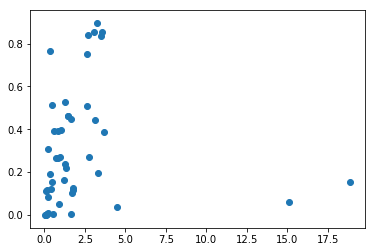

In [90]:
plt.scatter(y=df['Precision'], x=df['freq_p'])

**Evaluating the level performance for (Recall vs Precision) vs Size**

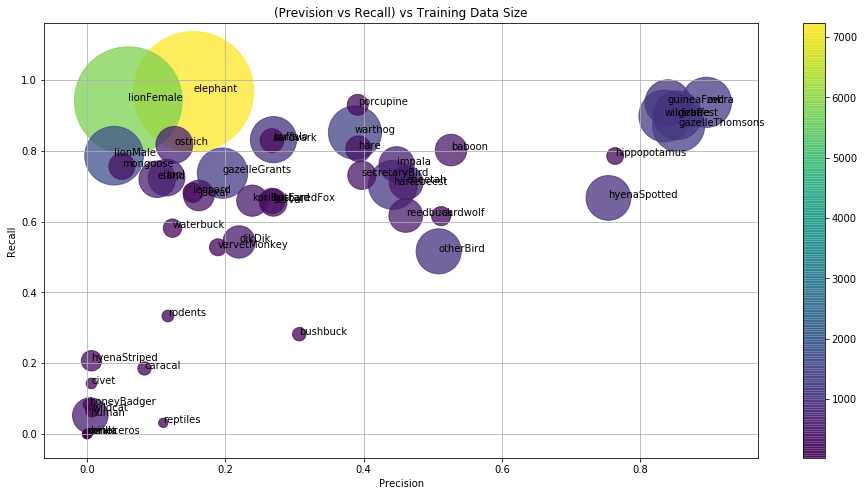

In [2]:
import matplotlib.pyplot as plt

species_performance_metric = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/EDA_and_ModelEvaluation/metric_temp.csv'

df_vis = pd.read_csv(species_performance_metric)
x = df_vis['Precision']
y = df_vis['Recall']

fig, ax = plt.subplots(figsize=(16, 8))
im = ax.scatter(x, y, c=df_vis['Training_Data_Size'],\
            s=2*df_vis['Training_Data_Size'], alpha=0.75)

for i, txt in enumerate(df_vis['Species']):
    ax.annotate(txt, (x[i], y[i]))
ax.set_title('(Prevision vs Recall) vs Training Data Size')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

fig.colorbar(im)
ax.grid()
ax.plot()
plt.show()



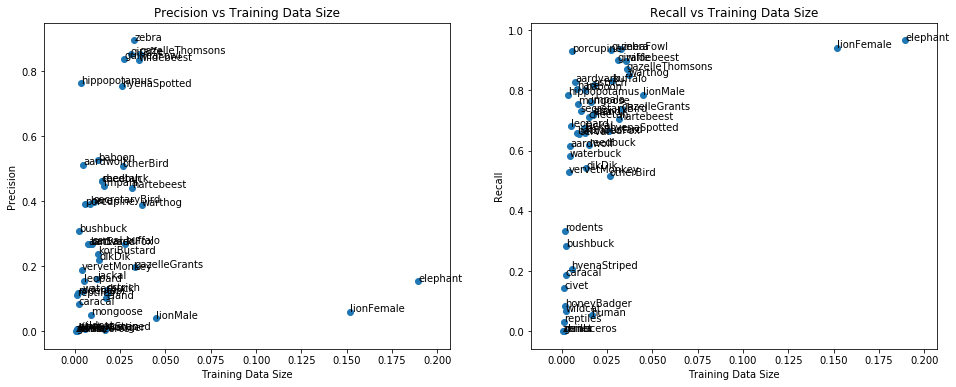

In [3]:
# Plot of training data distribution vs precision and recall
df_vis = pd.read_csv(species_performance_metric)
x = df_vis['Training_Data_freq_normalized']
y1 = df_vis['Precision']
y2 = df_vis['Recall']

fig, (ax1, ax2) = plt.subplots(figsize=(16, 6), ncols=2)
# figure 1
im = ax1.scatter(x, y1)

for i, txt in enumerate(df_vis['Species']):
    ax1.annotate(txt, (x[i], y1[i]))
ax1.set_title('Precision vs Training Data Size')
ax1.set_xlabel('Training Data Size')
ax1.set_ylabel('Precision')
ax1.plot()

# figure 2
im = ax2.scatter(x, y2)

for i, txt in enumerate(df_vis['Species']):
    ax2.annotate(txt, (x[i], y2[i]))
ax2.set_title('Recall vs Training Data Size')
ax2.set_xlabel('Training Data Size')
ax2.set_ylabel('Recall')
ax2.plot()

plt.show()